# Identify a MHW

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import dask
import dask.array as dsa
from xgcm import Grid
#import regionate as reg

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sst_trop_ds.zarr'))

In [3]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    sst = ds_sst.sst.load()

In [4]:
sst

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
array([[[26.528534, 26.537628, 26.55774 , ...,       nan,       nan,
               nan],
        [26.541504, 26.543457, 26.555145, ...,       nan,       nan,
               nan],
        [26.55774 , 26.549927, 26.557068, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[26.528534, 26.537628, 26.55774 , ...,       nan,       nan,
               nan],
        [26.541504, 26.543457, 26.555145, ...,       nan,       nan,
               nan],
        [26.55774 , 26.549927, 26.557068, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

# 95/99$^{tdim= percentile

In [18]:
q99 = sst.quantile(0.99, dim='time')
q95 = sst.quantile(0.95, dim='time')

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [19]:
q99

<xarray.DataArray 'sst' (latitude: 109, longitude: 401)>
array([[30.15731903, 30.22061768, 30.24614166, ...,         nan,
                nan,         nan],
       [30.22820862, 30.30125397, 30.2943158 , ...,         nan,
                nan,         nan],
       [30.30224091, 30.33683624, 30.32345551, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
    quantile   float64 0.99

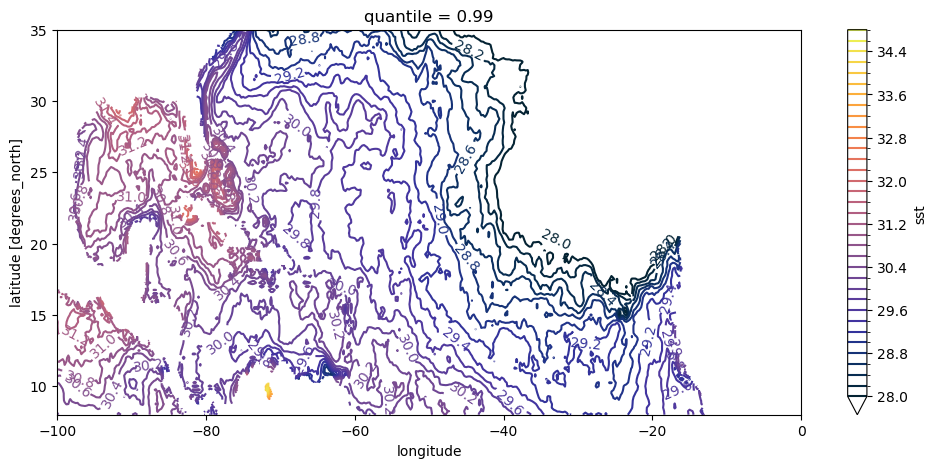

In [20]:
theta_levs = np.arange(28,35,0.2)

fig, ax = plt.subplots(figsize=(12,5))
C = q99.plot.contour(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)
plt.clabel(C);

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


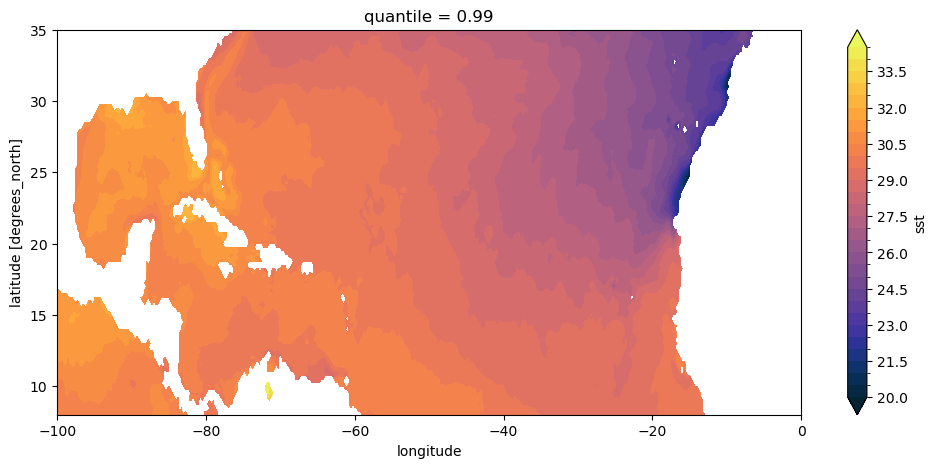

In [16]:
theta_levs = np.arange(20,35,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = q99.plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)

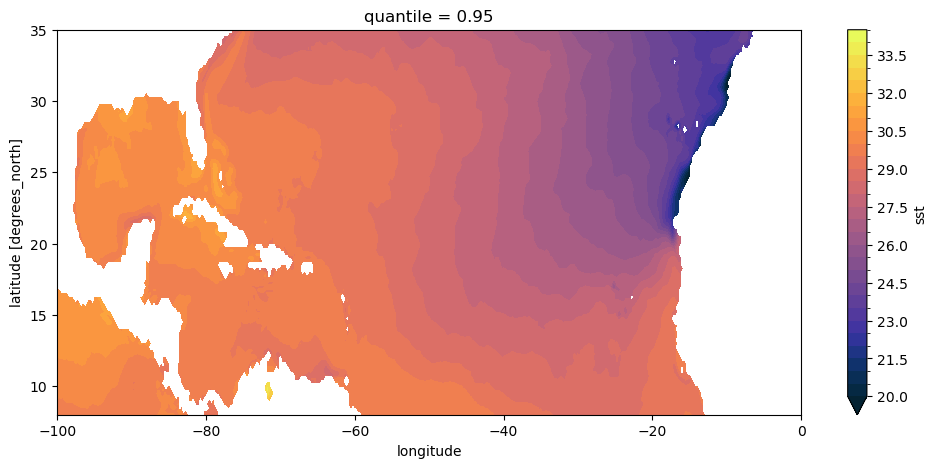

In [17]:
theta_levs = np.arange(20,35,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = q95.plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)

In [24]:
q99.max().values, q95.max().values

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


(array(34.51864624), array(33.58800049))

- Max SST in 99$^{th}$ percentile = 34.52 $^{\circ}$C
- Max SST in 95$^{th}$ percentile = 33.59 $^{\circ}$C

# Compute daily/monthly climatology and anomaly

In [14]:
#resample to daily to get rid of diurnal cycle
sst_resampled = sst.resample(time='D').mean()

In [15]:
sst_resampled

<xarray.DataArray 'sst' (time: 2097, latitude: 109, longitude: 401)>
array([[[26.536535, 26.544924, 26.564497, ...,       nan,       nan,
               nan],
        [26.550262, 26.55124 , 26.561903, ...,       nan,       nan,
               nan],
        [26.56682 , 26.557604, 26.56334 , ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[26.620056, 26.62194 , 26.636337, ...,       nan,       nan,
               nan],
        [26.64055 , 26.632006, 26.632067, ...,       nan,       nan,
               nan],
        [26.658876, 26.63514 , 26.626379, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28

In [17]:
#daily clim
#with dask.config.set(**{'array.slicing.split_large_chunks': True}):

clim = sst_resampled.groupby('time.dayofyear').mean('time')
#clim_std = sst_resampled.groupby('time.dayofyear').std('time')
anom = sst_resampled.groupby('time.dayofyear') - clim

#monthly clim
mo_clim = sst_resampled.groupby('time.month').mean('time')
#mo_clim_std = sst_resampled.groupby('time.month').std('time')
mo_anom = sst_resampled.groupby('time.month') - mo_clim

In [61]:
anom_fl = anom.sel(latitude=slice(22, None), longitude=slice(-90, -75))

In [62]:
anom_fl.sel(time='2023-07-13', method='nearest')

<xarray.DataArray 'sst' (latitude: 53, longitude: 61)>
array([[-0.10339928, -0.15840721, -0.15753746, ...,  0.7453003 ,
         0.7352047 ,  0.6747112 ],
       [ 0.18691254,  0.24057579,  0.354784  , ...,  0.78439903,
         0.80631447,  0.7263603 ],
       [ 0.3750744 ,  0.40701675,  0.5926914 , ...,  0.7659817 ,
         0.7942257 ,  0.7548466 ],
       ...,
       [        nan,         nan,         nan, ...,  0.5188122 ,
         0.5614643 ,  0.70599556],
       [        nan,         nan,         nan, ...,  0.5564804 ,
         0.57045746,  0.5385132 ],
       [        nan,         nan,         nan, ...,  0.61600494,
         0.70438766,  0.73791504]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 34.5 34.75 35.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -75.5 -75.25 -75.0
    time       datetime64[ns] 2023-07-13
    dayofyear  int64 194

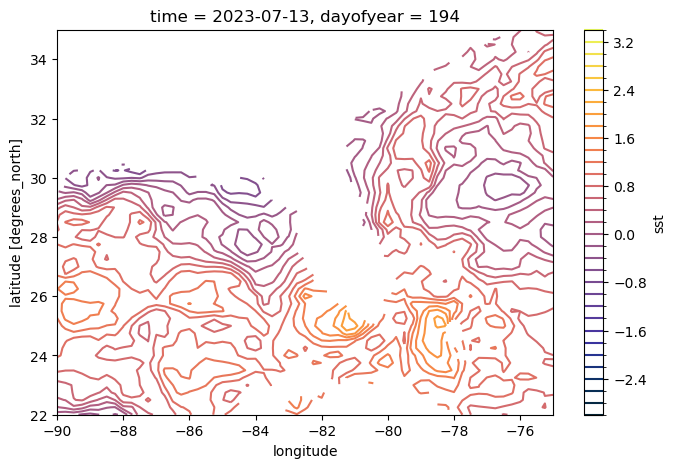

In [64]:
plt.figure(figsize=(8,5))
anom_fl.sel(time='2023-07-13', method='nearest').plot.contour(levels=np.arange(-3, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True);

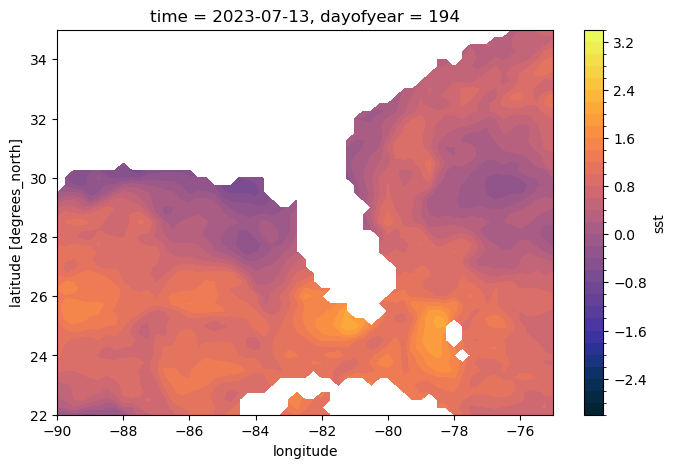

In [65]:
plt.figure(figsize=(8,5))
anom_fl.sel(time='2023-07-13', method='nearest').plot.contourf(levels=np.arange(-3, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True);

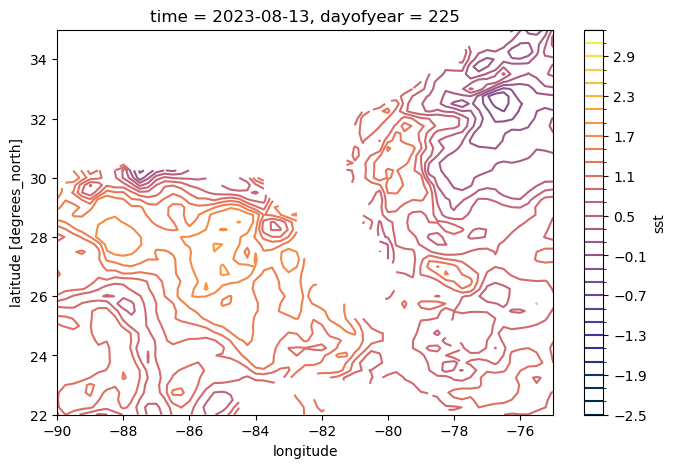

In [66]:
plt.figure(figsize=(8,5))
anom_fl.sel(time='2023-08-13', method='nearest').plot.contour(levels=np.arange(-2.5, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)

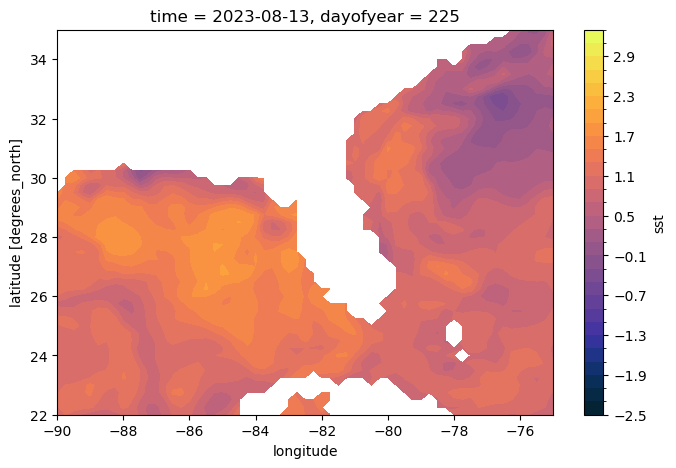

In [67]:
plt.figure(figsize=(8,5))
anom_fl.sel(time='2023-08-13', method='nearest').plot.contourf(levels=np.arange(-2.5, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True);

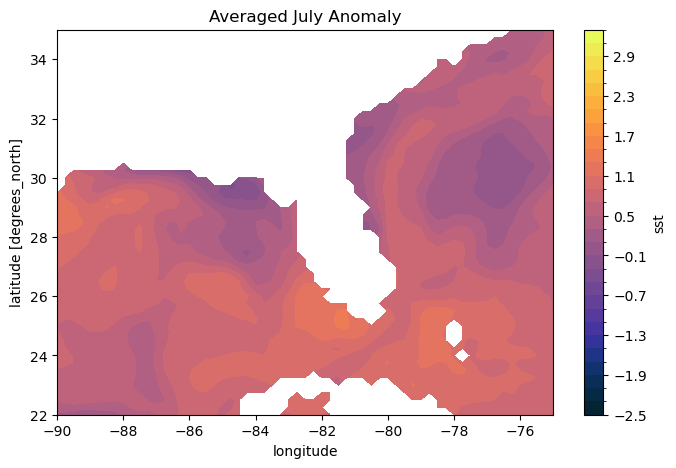

In [68]:
plt.figure(figsize=(8,5))
anom_fl.sel(time=slice('2023-07-01', '2023-07-31')).mean('time').plot.contourf(levels=np.arange(-2.5, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
plt.title('Averaged July Anomaly');

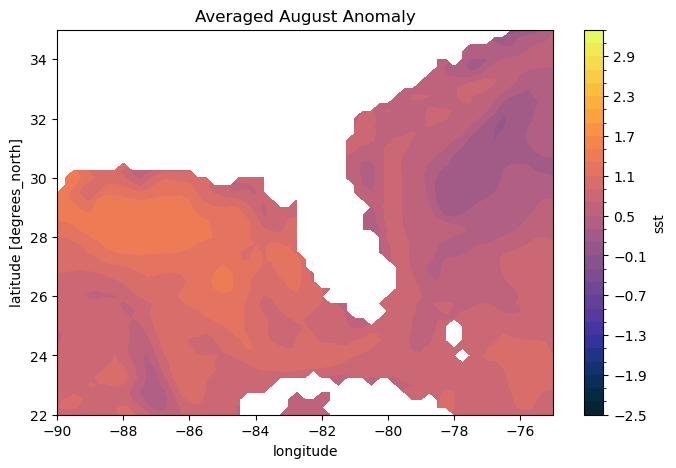

In [70]:
plt.figure(figsize=(8,5))
anom_fl.sel(time=slice('2023-08-01', '2023-08-31')).mean('time').plot.contourf(levels=np.arange(-2.5, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
plt.title('Averaged August Anomaly');

In [84]:
idxmax_july = anom_fl.sel(time=slice('2023-07-01', '2023-07-31')).idxmax(dim='time', skipna=True)
idxmax_aug = anom_fl.sel(time=slice('2023-08-01', '2023-08-31')).idxmax(dim='time', skipna=True)

In [85]:
idxmax_july

<xarray.DataArray 'time' (latitude: 53, longitude: 61)>
array([['2023-07-03T00:00:00.000000000', '2023-07-03T00:00:00.000000000',
        '2023-07-03T00:00:00.000000000', ...,
        '2023-07-06T00:00:00.000000000', '2023-07-03T00:00:00.000000000',
        '2023-07-03T00:00:00.000000000'],
       ['2023-07-03T00:00:00.000000000', '2023-07-03T00:00:00.000000000',
        '2023-07-03T00:00:00.000000000', ...,
        '2023-07-11T00:00:00.000000000', '2023-07-03T00:00:00.000000000',
        '2023-07-03T00:00:00.000000000'],
       ['2023-07-04T00:00:00.000000000', '2023-07-04T00:00:00.000000000',
        '2023-07-02T00:00:00.000000000', ...,
        '2023-07-11T00:00:00.000000000', '2023-07-03T00:00:00.000000000',
        '2023-07-03T00:00:00.000000000'],
       ...,
       [                          'NaT',                           'NaT',
                                  'NaT', ...,
        '2023-07-26T00:00:00.000000000', '2023-07-09T00:00:00.000000000',
        '2023-07-25T00:00:00.000000000'],
       [                          'NaT',                           'NaT',
                                  'NaT', ...,
        '2023-07-09T00:00:00.000000000', '2023-07-09T00:00:00.000000000',
        '2023-07-09T00:00:00.000000000'],
       [                          'NaT',                           'NaT',
                                  'NaT', ...,
        '2023-07-09T00:00:00.000000000', '2023-07-09T00:00:00.000000000',
        '2023-07-09T00:00:00.000000000']], dtype='datetime64[ns]')
Coordinates:
    dayofyear  (latitude, longitude) int64 184 184 184 183 ... 207 190 190 190
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 34.5 34.75 35.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -75.5 -75.25 -75.0

In [86]:
argmax_july = anom_fl.sel(time=slice('2023-07-01', '2023-07-31')).fillna(0.).argmax(dim='time')
argmax_aug = anom_fl.sel(time=slice('2023-08-01', '2023-08-31')).fillna(0.).argmax(dim='time')

In [87]:
argmax_july

<xarray.DataArray 'sst' (latitude: 53, longitude: 61)>
array([[ 2,  2,  2, ...,  5,  2,  2],
       [ 2,  2,  2, ..., 10,  2,  2],
       [ 3,  3,  1, ..., 10,  2,  2],
       ...,
       [ 0,  0,  0, ..., 25,  8, 24],
       [ 0,  0,  0, ...,  8,  8,  8],
       [ 0,  0,  0, ...,  8,  8,  8]])
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 34.5 34.75 35.0
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -75.5 -75.25 -75.0

In [88]:
argmax_july.values.max()

30

In [90]:
argmax_aug.max().values

array(30)

In [77]:
anom_fl.sel(time=slice('2023-08-01', '2023-08-31')).time[30]

<xarray.DataArray 'time' ()>
array('2023-08-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time       datetime64[ns] 2023-08-31
    dayofyear  int64 243

In [91]:
anom_fl.sel(time=slice('2023-07-01', '2023-07-31')).time[30]

<xarray.DataArray 'time' ()>
array('2023-07-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time       datetime64[ns] 2023-07-31
    dayofyear  int64 212

In [78]:
anom_fl.sel(time=slice('2023-08-01', '2023-08-31')).time[30].max().values

numpy.datetime64('2023-08-31T00:00:00.000000000')

In [95]:
anom_fl.sel(time=slice('2023-07-01', '2023-07-31')).max().values

array(2.20454025)

In [94]:
anom_fl.sel(time=slice('2023-08-01', '2023-08-31')).max().values

array(2.48595238)

In [118]:
np.arange(-3, 3.5, 0.2)[-9]

1.8000000000000043

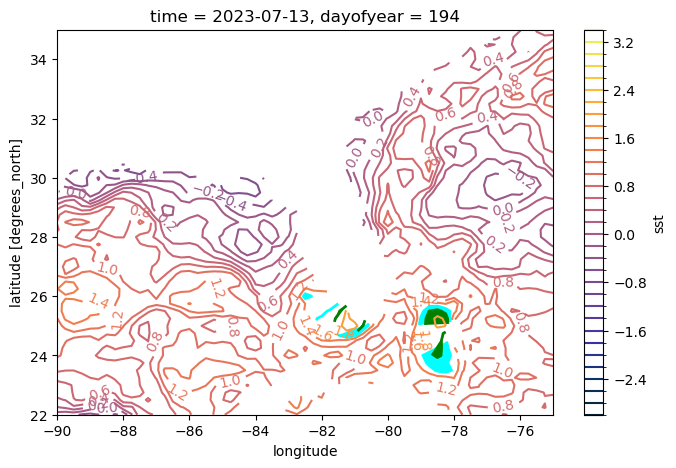

In [119]:
plt.figure(figsize=(8,5))
c = anom_fl.sel(time='2023-07-13', method='nearest').plot.contour(levels=np.arange(-3, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c.collections[-10].set_color('cyan') #+1.6
c.collections[-10].set_linewidth(2)
c.collections[-9].set_color('green') #+1.8
c.collections[-9].set_linewidth(2)
plt.clabel(c);

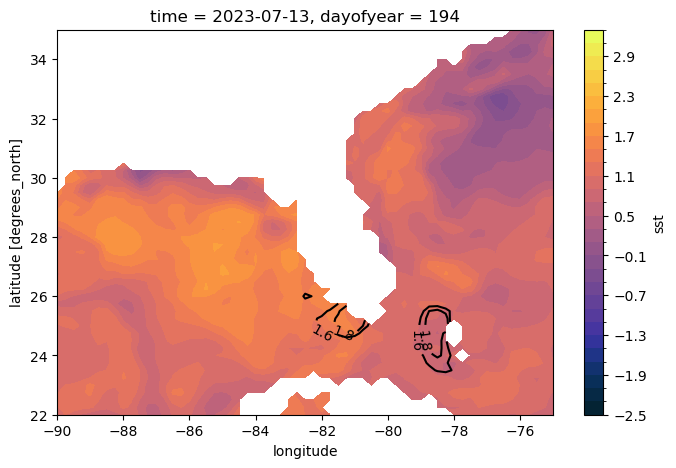

In [121]:
plt.figure(figsize=(8,5))
anom_fl.sel(time='2023-08-13', method='nearest').plot.contourf(levels=np.arange(-2.5, 3.5, 0.2), 
                                                           colors=cmocean.cm.thermal, add_colorbar=True)
c = anom_fl.sel(time='2023-07-13', method='nearest').plot.contour(levels=[1.6, 1.8], colors='k')
plt.clabel(c);

In [96]:
lat_max_july = anom_fl.sel(time=slice('2023-07-01', 
                                 '2023-07-31')).isel(time=30).fillna(0.).argmax(dim=['latitude', 'longitude'])
lat_max_aug = anom_fl.sel(time=slice('2023-08-01', 
                                 '2023-08-31')).isel(time=30).fillna(0.).argmax(dim=['latitude', 'longitude'])

In [97]:
lat_max

{'latitude': <xarray.DataArray 'sst' ()>
 array(6)
 Coordinates:
     time       datetime64[ns] 2023-08-31
     dayofyear  int64 243,
 'longitude': <xarray.DataArray 'sst' ()>
 array(57)
 Coordinates:
     time       datetime64[ns] 2023-08-31
     dayofyear  int64 243}

In [82]:
anom.latitude[6]

<xarray.DataArray 'latitude' ()>
array(9.5, dtype=float32)
Coordinates:
    latitude  float32 9.5
Attributes:
    long_name:  latitude
    units:      degrees_north

In [83]:
anom.longitude[57]

<xarray.DataArray 'longitude' ()>
array(-85.75, dtype=float32)
Coordinates:
    longitude  float32 -85.75

# Find temp above 90$^{th}$ percentile threshold

In [21]:
above_thr99 = sst.where(sst>=q99, other=np.nan)
above_thr95 = sst.where(sst>=q95, other=np.nan)

above_thr95.compute()

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
    quantile   float64 0.95

In [22]:
above_thr99.compute()

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
    quantile   float64 0.99

In [8]:
#see what local dask is doing in the background 
from dask.distributed import LocalCluster, Client
import dask

with dask.config.set(**{"distributed.dashboard.link": "/user/{JUPYTERHUB_USER}/proxy/{port}/status"}):
    cluster = LocalCluster()
    client = Client(cluster)

In [9]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/shanicetbailey/proxy/8787/status,
Dashboard: /user/shanicetbailey/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 125.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33381,Workers: 4
Dashboard: /user/shanicetbailey/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 125.81 GiB
Comm: tcp://127.0.0.1:39271,Total threads: 4
Dashboard: /user/shanicetbailey/proxy/39247/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:37665,


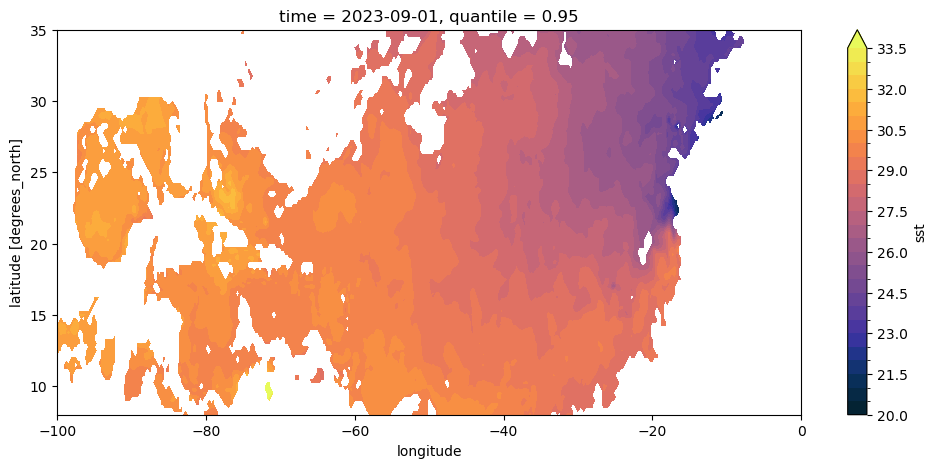

In [37]:
theta_levs = np.arange(20,34,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = above_thr95.sel(time='2023-09-01', method='nearest').plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                     ax=ax, add_colorbar=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


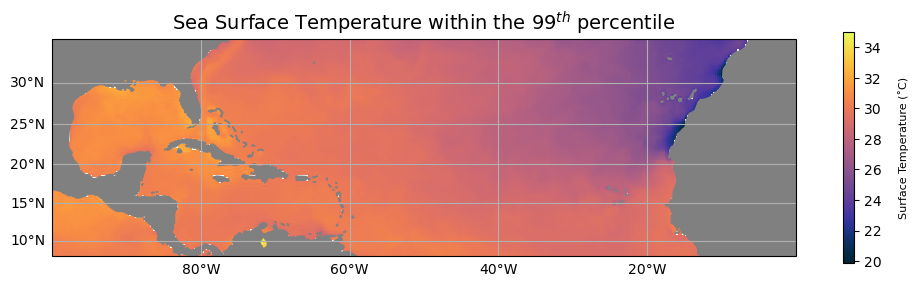

In [ ]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(12, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-100, 0, 8, 35], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(q99.longitude, q99.latitude, q99, levels=[q99.max()], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(q99.longitude, q99.latitude, q99, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.2)
cb.set_label("Surface Temperature (˚C)", labelpad=12, fontsize=8)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Sea Surface Temperature within the 99$^{th}$ percentile', fontsize=14);

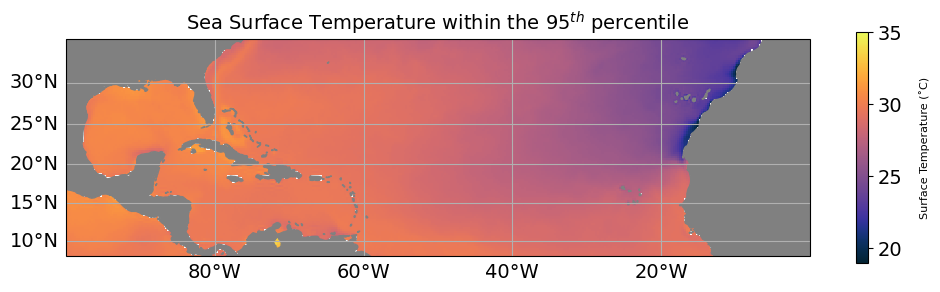

In [60]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(12, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-100, 0, 8, 35], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
c = ax.contour(q95.longitude, q95.latitude, q95, levels=[q95.max().values], colors='k', linewidths=2, transform=ccrs.PlateCarree())
plt.clabel(c)

im = ax.pcolormesh(q95.longitude, q95.latitude, q95, transform=ccrs.PlateCarree(), cmap=cmocean.cm.thermal, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.2)
cb.set_label("Surface Temperature (˚C)", labelpad=12, fontsize=8)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Sea Surface Temperature within the 95$^{th}$ percentile', fontsize=14);

In [125]:
maxt = above_thr99.where(above_thr99==34.52)

In [127]:
dtmax = maxt.time.groupby('time.year').count()

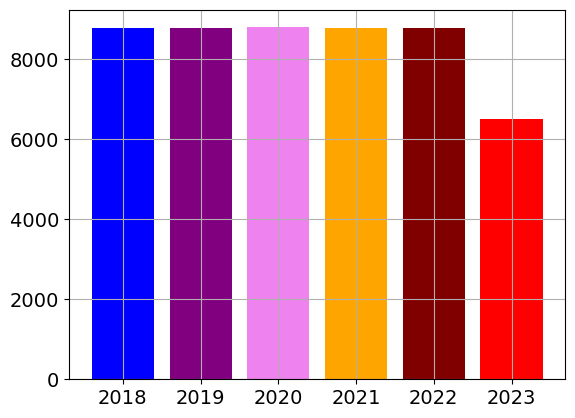

In [128]:
colors = ['blue', 'purple', 'violet', 'orange', 'maroon', 'red']
plt.bar(dtmax.year, dtmax, color=colors)
plt.grid()

In [25]:
dty = above_thr99.time.groupby('time.year').count()
dt2023 = above_thr99.sel(time=slice('2023-01', '2023-09')).time.groupby('time.month').count()

In [26]:
dty

<xarray.DataArray 'time' (year: 6)>
array([8760, 8760, 8784, 8760, 8760, 6485])
Coordinates:
    quantile  float64 0.99
  * year      (year) int64 2018 2019 2020 2021 2022 2023
Attributes:
    long_name:  time

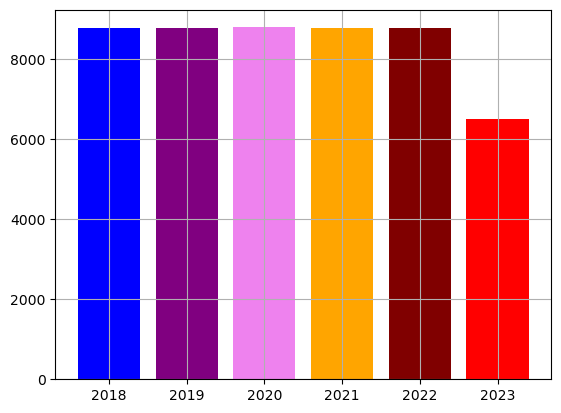

In [27]:
colors = ['blue', 'purple', 'violet', 'orange', 'maroon', 'red']
plt.bar(dty.year, dty, color=colors)
plt.grid()

In [28]:
dt2023

<xarray.DataArray 'time' (month: 9)>
array([744, 672, 744, 720, 744, 720, 744, 744, 653])
Coordinates:
    quantile  float64 0.99
  * month     (month) int64 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:  time

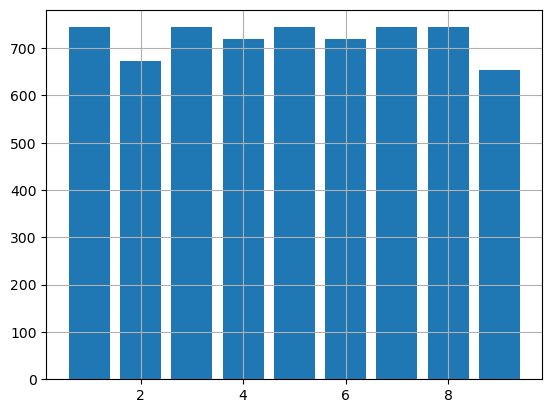

In [29]:
plt.bar(dt2023.month, dt2023)
plt.grid()

# Movie

- Max SST in 99$^{th}$ percentile = 34.52 $^{\circ}$C
- Max SST in 95$^{th}$ percentile = 33.59 $^{\circ}$C

In [129]:
resampled_maxt = maxt.resample(time='D').mean()
loaded_maxt = resampled_maxt.load()

In [43]:
resampled99 = above_thr99.resample(time='D').mean()
resampled95 = above_thr95.resample(time='D').mean()

In [44]:
loaded_sst99 = resampled99.compute()
loaded_sst95 = resampled95.compute()

In [45]:
loaded_sst95

<xarray.DataArray 'sst' (time: 2097, latitude: 109, longitude: 401)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
    quantile   float64 0.95
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28

In [30]:
from xmovie import Movie
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [114]:
import cmocean

def contour_surf(da, fig, tt, *args, **kwargs):
    ax = fig.subplots()
    theta_levs = np.arange(20,35,0.5)
    
    Cf = da.isel(time=tt).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)
    ax.grid()

    return ax, Cf

In [105]:
sst_2023 = loaded_sst99.sel(time=slice('2023-01' ,'2023-10'))

(<Axes: title={'center': 'quantile = 0.99, time = 2023-01-01'}, xlabel='longitude', ylabel='latitude [degrees_north]'>,
 <matplotlib.contour.QuadContourSet at 0x7feee4f3eda0>)

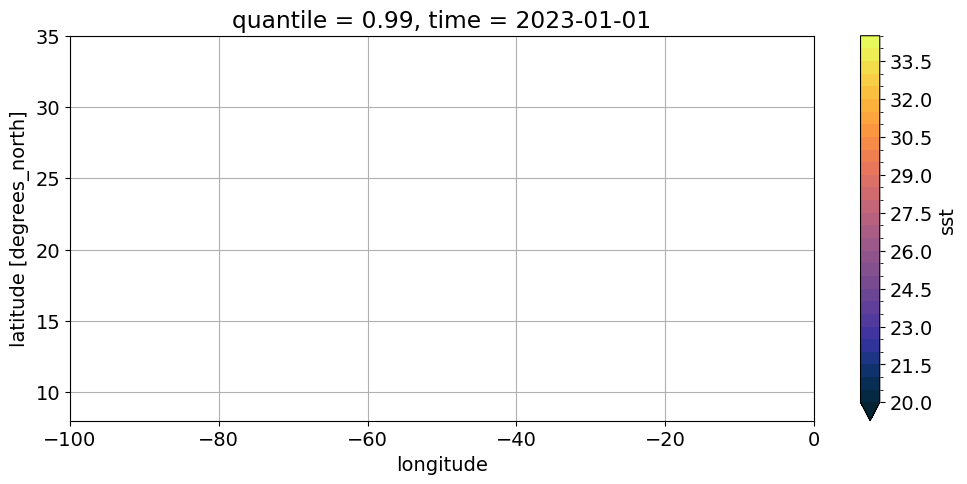

In [115]:
fig99 = plt.figure(figsize=(12, 5))

contour_surf(sst_2023, fig99, 0)

In [108]:
sst99 = Movie(sst_2023, contour_surf, input_check=False)
#sst95 = Movie(loaded_sst95, contour_surf, input_check=False)

2023-10-18 19:46:55,710 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


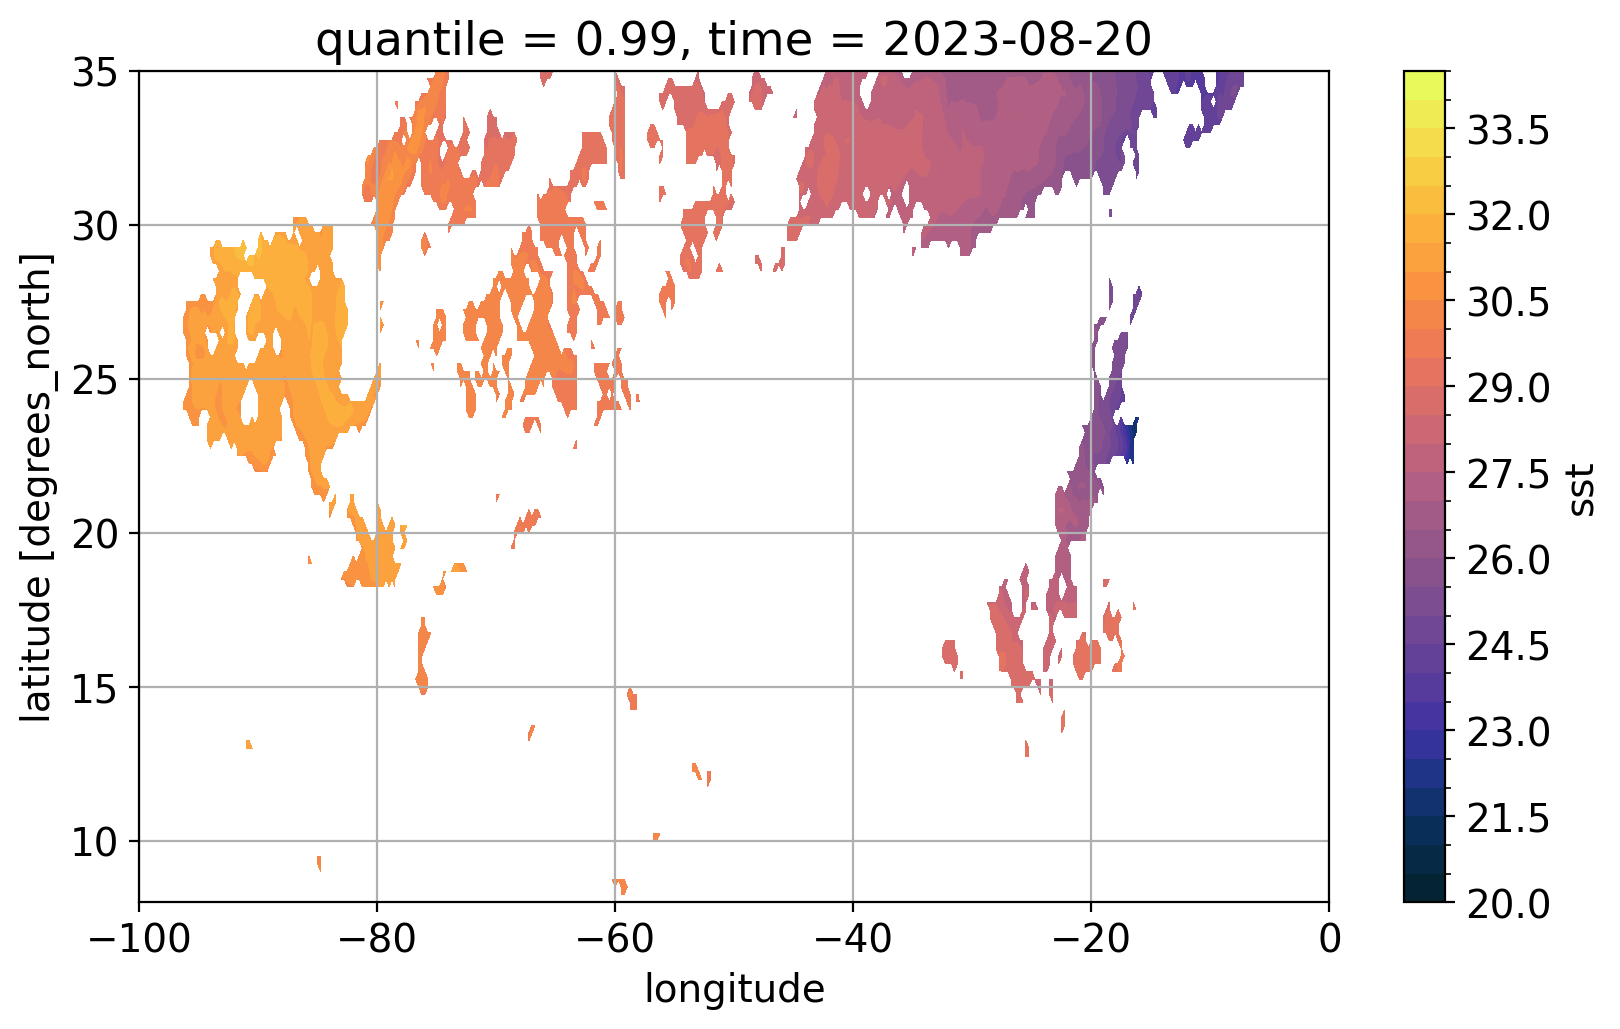

In [109]:
sst99.preview(-40)

In [110]:
#save sstmovie
sst99.save('sst_above_thr99_daily-2023.mp4', progress=True, overwrite_existing=True)

  0%|          | 0/271 [00:00<?, ?it/s]

2023-10-18 19:47:04,239 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-10-18 19:47:05,077 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-10-18 19:47:05,869 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-10-18 19:47:06,627 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-10-18 19:47:07,410 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-10-18 19:47:08,190 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-10-18 19:47:08,966 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-10-18 19:47:09,740 - distributed.utils_perf - WARNING - full garbage collections took

Movie created at sst_above_thr99_daily-2023.mp4


In [134]:
import cmocean

def contour_max(da, fig, tt, *args, **kwargs):
    ax = fig.subplots()
    
    Cf = da.isel(time=tt).plot.contour(colors='k', levels=34.52, 
                                                                ax=ax, add_colorbar=True)
    ax.grid()

    return ax, Cf

(<Axes: title={'center': 'quantile = 0.99, time = 2018-01-01'}, xlabel='longitude', ylabel='latitude [degrees_north]'>,
 <matplotlib.contour.QuadContourSet at 0x7feeeda3c5e0>)

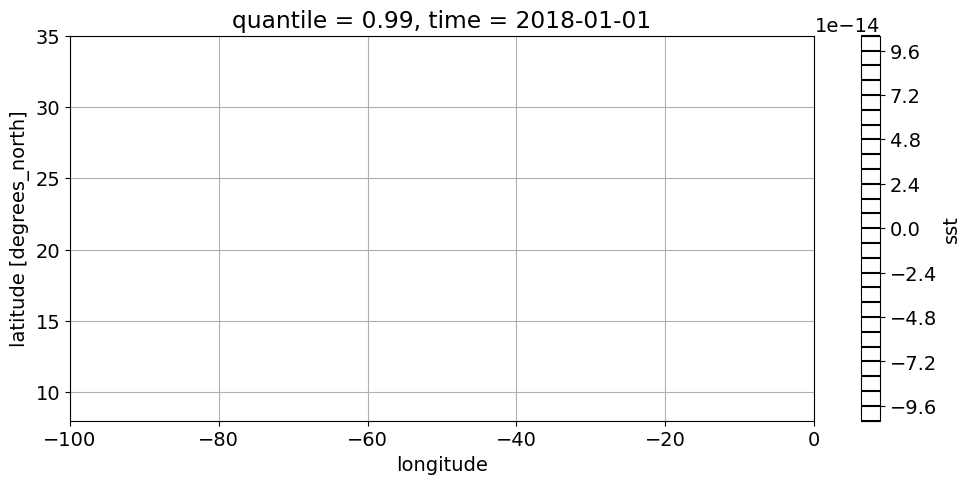

In [135]:
fig = plt.figure(figsize=(12, 5))

contour_max(loaded_maxt, fig, 0)

In [136]:
sst_max = Movie(loaded_maxt, contour_max, input_check=False)

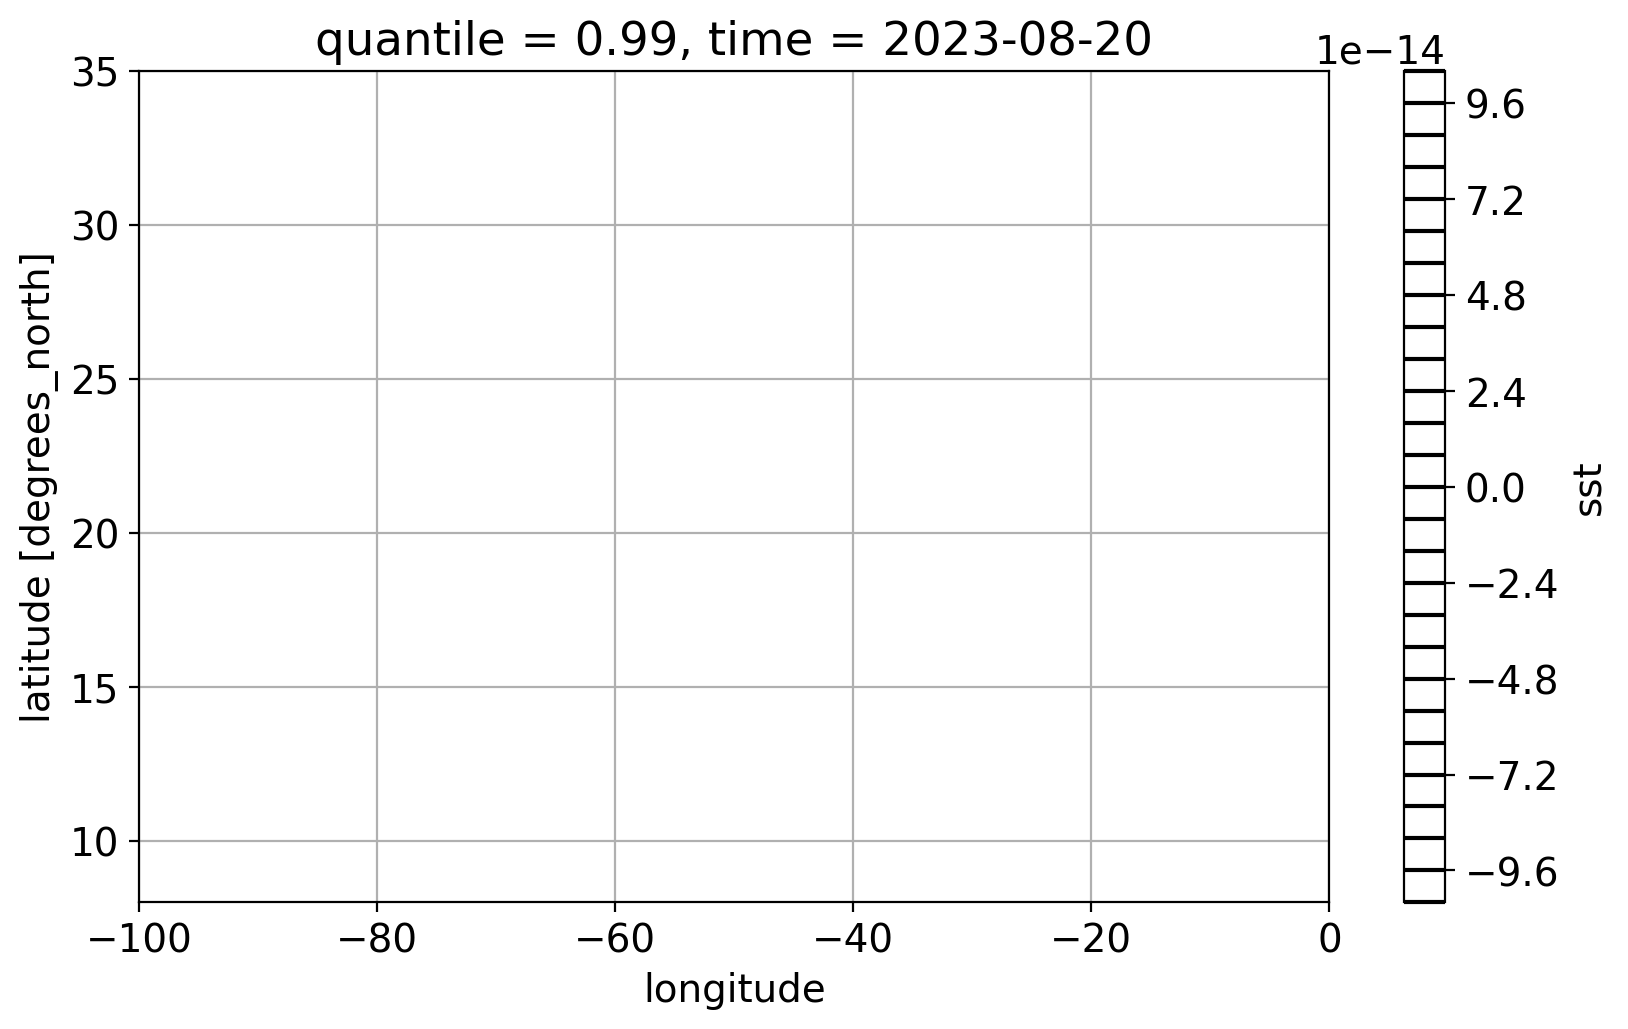

In [137]:
sst_max.preview(-35)

# Find when/where max temp in both percentiles exist

- Max SST in 99$^{th}$ percentile = 34.52 $^{\circ}$C
- Max SST in 95$^{th}$ percentile = 33.59 $^{\circ}$C

In [23]:
resampled99 = above_thr99.resample(time='D').mean()
resampled95 = above_thr95.resample(time='D').mean()

In [24]:
loaded_sst99 = resampled99#.compute()
loaded_sst95 = resampled95#.compute()

In [25]:
loaded_sst95

<xarray.DataArray 'sst' (time: 2097, latitude: 109, longitude: 401)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
    quantile   float64 0.95
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28

In [5]:
idxmax = sst.idxmax(dim='time', skipna=True)

In [6]:
idxmax

<xarray.DataArray 'time' (latitude: 109, longitude: 401)>
array([['2023-05-15T22:00:00.000000000', '2023-05-24T22:00:00.000000000',
        '2023-05-24T22:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2023-05-15T22:00:00.000000000', '2023-05-16T22:00:00.000000000',
        '2023-05-22T22:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2023-05-16T22:00:00.000000000', '2023-05-16T22:00:00.000000000',
        '2023-05-16T22:00:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ...,
       [                          'NaT',                           'NaT',
                                  'NaT', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       [                          'NaT',                           'NaT',
                                  'NaT', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       [                          'NaT',                           'NaT',
                                  'NaT', ...,
                                  'NaT',                           'NaT',
                                  'NaT']], dtype='datetime64[ns]')
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0

In [7]:
argmax = sst.fillna(0.).argmax(dim='time')

In [8]:
argmax

<xarray.DataArray 'sst' (latitude: 109, longitude: 401)>
array([[47062, 47278, 47278, ...,     0,     0,     0],
       [47062, 47086, 47230, ...,     0,     0,     0],
       [47086, 47086, 47086, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]])
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0

In [9]:
argmax.values.max()

50278

In [10]:
sst.time[50278]

<xarray.DataArray 'time' ()>
array('2023-09-26T22:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2023-09-26T22:00:00
Attributes:
    long_name:  time

In [11]:
sst.isel(time=50278).max().values

array(34.57821655)

In [12]:
lat_max = sst.isel(time=50278).fillna(0.).argmax(dim=['latitude', 'longitude'])

In [13]:
lat_max

{'latitude': <xarray.DataArray 'sst' ()>
 array(7)
 Coordinates:
     time     datetime64[ns] 2023-09-26T22:00:00,
 'longitude': <xarray.DataArray 'sst' ()>
 array(113)
 Coordinates:
     time     datetime64[ns] 2023-09-26T22:00:00}

In [14]:
sst[50278, 7, 113]

<xarray.DataArray 'sst' ()>
array(34.578217, dtype=float32)
Coordinates:
    latitude   float32 9.75
    longitude  float32 -71.75
    time       datetime64[ns] 2023-09-26T22:00:00

In [15]:
sst.latitude[7]

<xarray.DataArray 'latitude' ()>
array(9.75, dtype=float32)
Coordinates:
    latitude  float32 9.75
Attributes:
    long_name:  latitude
    units:      degrees_north

In [16]:
sst.longitude[113]

<xarray.DataArray 'longitude' ()>
array(-71.75, dtype=float32)
Coordinates:
    longitude  float32 -71.75

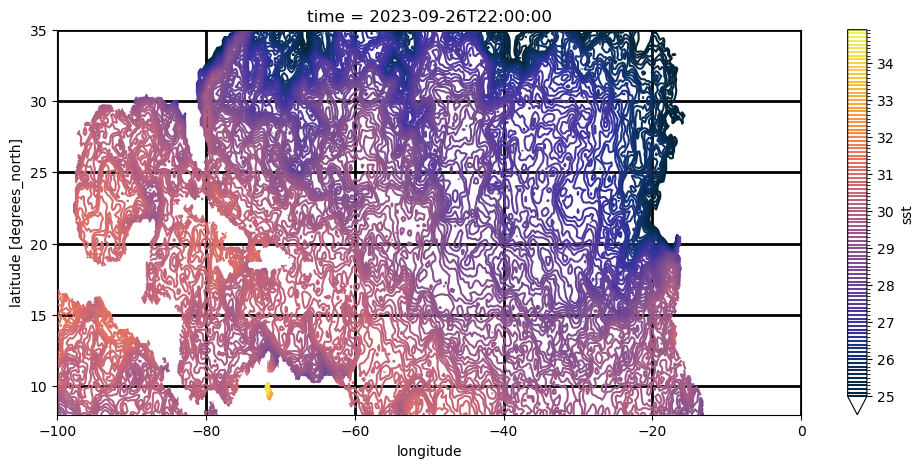

In [17]:
fig, ax = plt.subplots(figsize=(12,5))
theta_levs = np.arange(25, 35, 0.1)
c = sst.isel(time=50278).plot.contour(levels=theta_levs, colors=cmocean.cm.thermal, add_colorbar=True, ax=ax)
#c = sst.isel(time=50278).plot.contourf(levels=theta_levs, colors=cmocean.cm.thermal, add_colorbar=True, ax=ax)
c.collections[-2].set_color('green')
c.collections[-2].set_linewidth(5)
#plt.clabel(c)
plt.grid(color='k', linewidth=2)

# Identify - from Henri's nb

In [28]:
ds_sst.longitude

<xarray.DataArray 'longitude' (longitude: 401)>
array([-100.  ,  -99.75,  -99.5 , ...,   -0.5 ,   -0.25,    0.  ],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0

In [27]:
0.25/2

0.125

In [38]:
lat_c = ds_sst.latitude.values + 0.125
lon_c = ds_sst.longitude.values + 0.125

In [39]:
sst_cc = ds_sst.assign_coords({'longitude_c':lon_c, 'latitude_c':lat_c})

In [40]:
sst_cc

<xarray.Dataset>
Dimensions:      (latitude: 109, longitude: 401, time: 50309, longitude_c: 401,
                  latitude_c: 109)
Coordinates:
  * latitude     (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude    (longitude) float32 -100.0 -99.75 -99.5 ... -0.5 -0.25 0.0
  * time         (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
  * longitude_c  (longitude_c) float32 -99.88 -99.62 -99.38 ... -0.125 0.125
  * latitude_c   (latitude_c) float32 8.125 8.375 8.625 ... 34.62 34.88 35.12
Data variables:
    sst          (time, latitude, longitude) float32 26.53 26.54 ... nan nan

In [41]:
grid = Grid(sst_cc, coords = {'X' : {'center':'longitude', 'right':'longitude_c'},
                           'Y' : {'center':'latitude', 'right':'latitude_c'},
                           'T' : {'center':'time'}},
           periodic=['X'])

In [42]:
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   longitude --> right
  * right    longitude_c --> center
Y Axis (not periodic, boundary=None):
  * center   latitude --> right
  * right    latitude_c --> center
T Axis (not periodic, boundary=None):
  * center   time

In [18]:
area = ds_sst.latitude * ds_sst.longitude

In [20]:
import regionate as reg

In [22]:
reg.grid_boundaries_from_mask()

<module 'regionate' from '/srv/conda/envs/notebook/lib/python3.10/site-packages/regionate/__init__.py'>

In [23]:
def masked_area(grid, mask):
    return (mask * area).sum(['xh', 'yh'])

def large_contiguous_regions(grid, mask, cutoff=(370e3)**2):
    lon_c, lat_c = reg.grid_boundaries_from_mask(grid, mask)
    regions = {}
    for r in range(len(i)):
        rmask = reg.mask_from_grid_boundaries(lon_c[r], lat_c[r], grid)
        if masked_area(grid, rmask) >= cutoff:
            regions[r] = {
                'r': r,
                'lon_c': lon_c[r],
                'lat_c': lat_c[r],
                'mask': rmask
            }
    return regions

In [24]:
large_contiguous_regions(grid, loaded_sst95)

ValueError: Horizontal grid axes ('X', 'Y') must be either both symmetric or both non-symmetric (by MOM6 conventions).